# TD4 - Explainability AI

#### Matias OTTENSEN
#### Tiphaine KACHKACHI
#### Manon GARDIN

# Our dataset 

Petite description du dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sklearn
from sklearn.datasets import load_diabetes
import shap

TypeError: 'numpy._DTypeMeta' object is not subscriptable

In [2]:
df = pd.read_csv('archive/US_Accidents_March23.csv', sep=',')

## Observe data

In [3]:
df.shape

(7728394, 46)

We have a great number of lines in our dataset.\
Also we have 46 columns, we probably won't need every one of them. Let's see their name :

In [4]:
df.columns

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [5]:
df.head(10)

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day
5,A-6,Source2,3,2016-02-08 07:44:26,2016-02-08 08:14:26,40.100590,-82.925194,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day
6,A-7,Source2,2,2016-02-08 07:59:35,2016-02-08 08:29:35,39.758274,-84.230507,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
7,A-8,Source2,3,2016-02-08 07:59:58,2016-02-08 08:29:58,39.770382,-84.194901,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day
8,A-9,Source2,2,2016-02-08 08:00:40,2016-02-08 08:30:40,39.778061,-84.172005,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
9,A-10,Source2,3,2016-02-08 08:10:04,2016-02-08 08:40:04,40.100590,-82.925194,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       

As the dataframe is huge (almost 3 gb), we decided to work on another version of this dataframe, just to have a sample that we could work on esier:

In [7]:
halfsize=int((df.shape[0])/2)
df_half= df.iloc[:halfsize,:]
print(df_half.shape)

(3864197, 46)


Variables like Street, City, Zipcode and County won't be useful to keep, because there are too many distinct values.\
The columns Bump, Traffic_calming, Turning_loop, Give_Way, No_Exit, Roundabout can be deleted because they take only one value (all false).\
The variable Country only takes US so we can delete it.\
We can also delete some columns like Airport_Code that won't be relevant.

In [8]:
# Delete the columns we don't need 
df = df.drop(['Street', 'City', 'Description','County', 'Zipcode', 'Country', 'Bump', 'Traffic_Calming', 'Turning_Loop', 'Give_Way', 'No_Exit', 'Roundabout', 'Airport_Code'], axis=1)

In [9]:
df.head(10)

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Crossing,Junction,Railway,Station,Stop,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,False,True,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,False,True,Day,Day,Day,Day
5,A-6,Source2,3,2016-02-08 07:44:26,2016-02-08 08:14:26,40.100590,-82.925194,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day
6,A-7,Source2,2,2016-02-08 07:59:35,2016-02-08 08:29:35,39.758274,-84.230507,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
7,A-8,Source2,3,2016-02-08 07:59:58,2016-02-08 08:29:58,39.770382,-84.194901,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day
8,A-9,Source2,2,2016-02-08 08:00:40,2016-02-08 08:30:40,39.778061,-84.172005,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
9,A-10,Source2,3,2016-02-08 08:10:04,2016-02-08 08:40:04,40.100590,-82.925194,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day


In [10]:
df.describe

<bound method NDFrame.describe of                 ID   Source  Severity           Start_Time  \
0              A-1  Source2         3  2016-02-08 05:46:00   
1              A-2  Source2         2  2016-02-08 06:07:59   
2              A-3  Source2         2  2016-02-08 06:49:27   
3              A-4  Source2         3  2016-02-08 07:23:34   
4              A-5  Source2         2  2016-02-08 07:39:07   
...            ...      ...       ...                  ...   
7728389  A-7777757  Source1         2  2019-08-23 18:03:25   
7728390  A-7777758  Source1         2  2019-08-23 19:11:30   
7728391  A-7777759  Source1         2  2019-08-23 19:00:21   
7728392  A-7777760  Source1         2  2019-08-23 19:00:21   
7728393  A-7777761  Source1         2  2019-08-23 18:52:06   

                    End_Time  Start_Lat   Start_Lng   End_Lat    End_Lng  \
0        2016-02-08 11:00:00  39.865147  -84.058723       NaN        NaN   
1        2016-02-08 06:37:59  39.928059  -82.831184       NaN        

# Data Cleaning

Missing values:

In [11]:
print(df.isnull().sum())

ID                             0
Source                         0
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  3402762
End_Lng                  3402762
Distance(mi)                   0
State                          0
Timezone                    7808
Weather_Timestamp         120228
Temperature(F)            163853
Wind_Chill(F)            1999019
Humidity(%)               174144
Pressure(in)              140679
Visibility(mi)            177098
Wind_Direction            175206
Wind_Speed(mph)           571233
Precipitation(in)        2203586
Weather_Condition         173459
Amenity                        0
Crossing                       0
Junction                       0
Railway                        0
Station                        0
Stop                           0
Traffic_Signal                 0
Sunrise_Sunset             23246
Civil_Twil

There are missing values, so, what can we do about it?

First, we create a new dataframe to secure the first one if we ever delete the wring values

In [12]:
newdf = df

We had to make a choice for each column on how to handle the missing values. We chose to keep every missing values, we did not delete any rows. We preferred to replace them with values that are easily readable for string values, and to use the average for the numerical values.

In [13]:
#for the end lat/lng : we will fill the NAN by the start lat/lng:

newdf['End_Lat']=newdf['End_Lat'].fillna(newdf['Start_Lat'])
newdf['End_Lng']=newdf['End_Lng'].fillna(newdf['Start_Lng'])

#for the streets/Cities/Description/timezone/Weather_Condition/Sunrise_Sunset/Civil_Twilight/Nautical_Twilight
#and Astronomical_Twilight, we just write "unknown", 
#as we do not want to give fake informations to the person reading

newdf['Timezone']=newdf['Timezone'].fillna('unknown')
newdf['Weather_Condition']=newdf['Weather_Condition'].fillna('unknown')
newdf['Sunrise_Sunset']=newdf['Sunrise_Sunset'].fillna('unknown')
newdf['Civil_Twilight']=newdf['Civil_Twilight'].fillna('unknown')
newdf['Nautical_Twilight']=newdf['Weather_Condition'].fillna('unknown')
newdf['Astronomical_Twilight']=newdf['Astronomical_Twilight'].fillna('unknown')

# for the weather timestamp, we put now's date
newdf['Weather_Timestamp']=newdf['Weather_Timestamp'].fillna(datetime.now())

#temperature/Wind_Chill(F)/Humidity(%)/Pressure(in)/Visibility(mi)/Wind_Speed(mph)/Precipitation(in): we put the mean
newdf['Temperature(F)']=newdf['Temperature(F)'].fillna(newdf['Temperature(F)'].mean())
newdf['Wind_Chill(F)']=newdf['Wind_Chill(F)'].fillna(newdf['Wind_Chill(F)'].mean())
newdf['Humidity(%)']=newdf['Humidity(%)'].fillna(newdf['Humidity(%)'].mean())
newdf['Pressure(in)']=newdf['Pressure(in)'].fillna(newdf['Pressure(in)'].mean())
newdf['Visibility(mi)']=newdf['Visibility(mi)'].fillna(newdf['Visibility(mi)'].mean())
newdf['Wind_Speed(mph)']=newdf['Wind_Speed(mph)'].fillna(newdf['Wind_Speed(mph)'].mean())
newdf['Precipitation(in)']=newdf['Precipitation(in)'].fillna(newdf['Precipitation(in)'].mean())


# for the airport code, we write '###' in the missing values
newdf['Wind_Direction']=newdf['Wind_Direction'].fillna('###')

In [14]:
print(newdf.isnull().sum())

ID                       0
Source                   0
Severity                 0
Start_Time               0
End_Time                 0
Start_Lat                0
Start_Lng                0
End_Lat                  0
End_Lng                  0
Distance(mi)             0
State                    0
Timezone                 0
Weather_Timestamp        0
Temperature(F)           0
Wind_Chill(F)            0
Humidity(%)              0
Pressure(in)             0
Visibility(mi)           0
Wind_Direction           0
Wind_Speed(mph)          0
Precipitation(in)        0
Weather_Condition        0
Amenity                  0
Crossing                 0
Junction                 0
Railway                  0
Station                  0
Stop                     0
Traffic_Signal           0
Sunrise_Sunset           0
Civil_Twilight           0
Nautical_Twilight        0
Astronomical_Twilight    0
dtype: int64


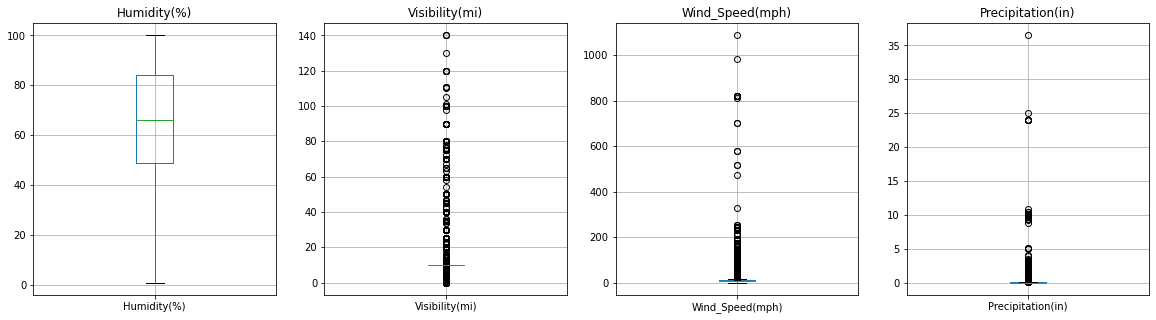

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

newdf[['Humidity(%)']].boxplot(ax=axes[0])
axes[0].set_title('Humidity(%)')

newdf[['Visibility(mi)']].boxplot(ax=axes[1])
axes[1].set_title('Visibility(mi)')

newdf[['Wind_Speed(mph)']].boxplot(ax=axes[2])
axes[2].set_title('Wind_Speed(mph)')

newdf[['Precipitation(in)']].boxplot(ax=axes[3])
axes[3].set_title('Precipitation(in)')

plt.show()

as we can see, there are a lot of outliers in the dataset, so let's remove them

C:\Users\manon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Visibility(mi)'>

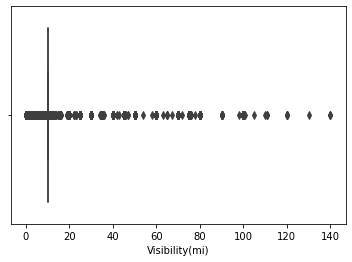

In [16]:
sns.boxplot(newdf['Visibility(mi)'])

Looks like there is a lot of outliers, so we decide to replace some outliers with the mean value

C:\Users\manon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Visibility(mi)'>

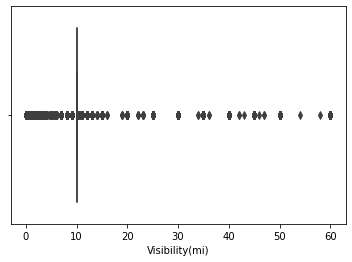

In [17]:
moyenne_colonne = newdf['Visibility(mi)'].mean()

newdf.loc[newdf['Visibility(mi)'] > 60, 'Visibility(mi)'] = 60

sns.boxplot(newdf['Visibility(mi)'])

As we can see, actually, there is a huge amount of "10" values, so the other values are more rare, so we can decide to keep it this way or to delete them. We chose to delete them, as they are not representative

Let's deal with every columns that contains outliers now.

In [18]:
Q1= newdf['Wind_Speed(mph)'].quantile(0.25)
Q3= newdf['Wind_Speed(mph)'].quantile(0.75)
IQR = Q3 - Q1
moyenne = newdf['Wind_Speed(mph)'].mean()

threshold = 1.5

newdf.loc[(df['Wind_Speed(mph)'] < Q1 - threshold * IQR), 'Wind_Speed(mph)'] = moyenne
newdf.loc[(df['Wind_Speed(mph)'] > Q3 + threshold * IQR), 'Wind_Speed(mph)'] = moyenne

#precipitaion

Q1= newdf['Precipitation(in)'].quantile(0.25)
Q3= newdf['Precipitation(in)'].quantile(0.75)
IQR = Q3 - Q1

threshold = 3


moyenne_precipitation = newdf['Precipitation(in)'].median()
newdf.loc[(df['Precipitation(in)'] < Q1 - threshold * IQR), 'Precipitation(in)'] = moyenne_precipitation
newdf.loc[(df['Precipitation(in)'] > Q3 + threshold * IQR), 'Precipitation(in)'] = moyenne_precipitation

#wind chill
Q1= newdf['Wind_Chill(F)'].quantile(0.25)
Q3= newdf['Wind_Chill(F)'].quantile(0.75)
IQR = Q3 - Q1

threshold = 1.5


moyenne_windchill = newdf['Wind_Chill(F)'].median()
newdf.loc[(df['Wind_Chill(F)'] < Q1 - threshold * IQR), 'Wind_Chill(F)'] = moyenne_windchill
newdf.loc[(df['Wind_Chill(F)'] > Q3 + threshold * IQR), 'Wind_Chill(F)'] = moyenne_windchill

#Temperature

Q1= newdf['Temperature(F)'].quantile(0.25)
Q3= newdf['Temperature(F)'].quantile(0.75)
IQR = Q3 - Q1

threshold = 1.5


moyenne_temp = newdf['Temperature(F)'].median()
newdf.loc[(df['Temperature(F)'] < Q1 - threshold * IQR), 'Temperature(F)'] = moyenne_temp
newdf.loc[(df['Temperature(F)'] > Q3 + threshold * IQR), 'Temperature(F)'] = moyenne_temp

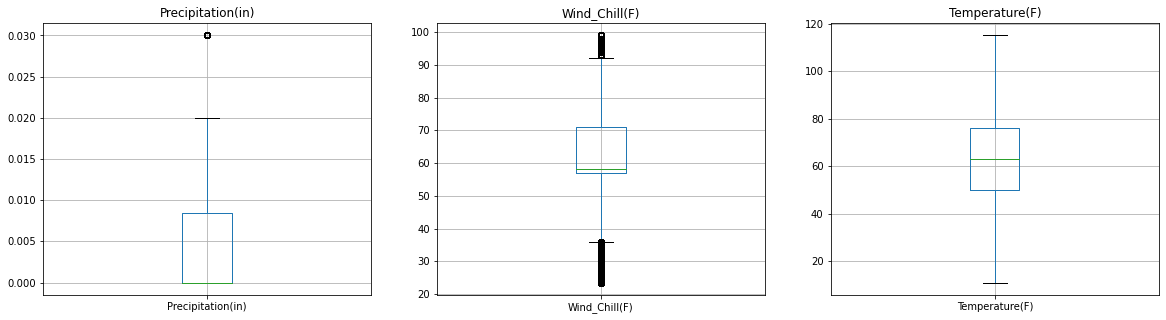

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

newdf[['Precipitation(in)']].boxplot(ax=axes[0])
axes[0].set_title('Precipitation(in)')

newdf[['Wind_Chill(F)']].boxplot(ax=axes[1])
axes[1].set_title('Wind_Chill(F)')

newdf[['Temperature(F)']].boxplot(ax=axes[2])
axes[2].set_title('Temperature(F)')

plt.show()

# Question 3

The variables we can predict are probably the severity of an accident, and maybe a start time.

Based on our intuition, we think that the most important variables to predict the severity of an accident would be the weather condition variables like Humidity, Wind Speed, Pressure, etc. And probably the time of the day like Day or Night.

## Univariate Analysis

Let's do a histogram

(array([  67366.,       0.,       0., 6156981.,       0.,       0.,
        1299337.,       0.,       0.,  204710.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

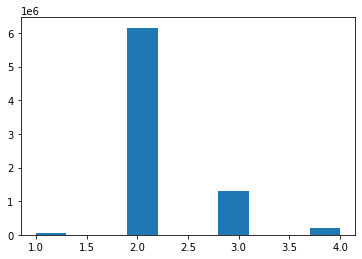

In [20]:
plt.hist(newdf['Severity'])

(array([2370595.,       0.,       0.,       0.,       0., 5334553.,
              0.,       0.,       0.,   23246.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

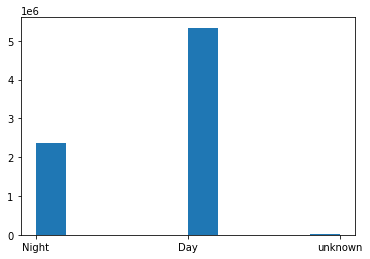

In [21]:
plt.hist(newdf['Sunrise_Sunset'])

In [22]:
#plt.scatter(newdf.index, newdf['Start_Time'])
#plt.show()

# Question 4

Here we are going to do a linear regression to predict values of new data for the dataset. 
Based on our intuition, we think that the most important variables to predict the severity of an accident would be the weather condition variables like Humidity or the time of the day like Day or Night, or even where it happened (what is on a stop, or a traffic sign ?)...


In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [23]:
newdf.info() #We check again which colomns we have and their type 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 33 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  State                  object 
 11  Timezone               object 
 12  Weather_Timestamp      object 
 13  Temperature(F)         float64
 14  Wind_Chill(F)          float64
 15  Humidity(%)            float64
 16  Pressure(in)           float64
 17  Visibility(mi)         float64
 18  Wind_Direction         object 
 19  Wind_Speed(mph)        float64
 20  Precipitation(in)      float64
 21  Weather_Condition      object 
 22  Amenity           

In [24]:
# Define target variable and predictor variables
X = newdf[['Visibility(mi)','Weather_Condition','Crossing','Junction','Station','Traffic_Signal','Stop','State','Precipitation(in)']] 
y = newdf['Severity']

After many test, to see which variables we should tale we decided to go with variable containing location informations (stop, state, traffic_signal...), variables linked to the condition (visibility, weather condition...).

In [25]:
# hot encoding on 'Weather_Condition' and 'State' columns as they are string colomns
X_encoded = pd.get_dummies(X, columns=['Weather_Condition','State'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [26]:
# Fit the linear regression model on the encoded data
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [27]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print("Training R^2 score:", train_score)
print("Testing R^2 score:", test_score)

# Where a higher value indicates a better fit of the model to the data.

Training R^2 score: 0.09004528988909655
Testing R^2 score: 0.09051023972881023


We got a Training R^2 score of around 0.09004. Knowing that the training R^2 score measures how well the model fits the training data. A high training R^2 score indicates that the model explains a large proportion of the variance in the training data. 

The testing R^2 score measures how well the model generalizes to new, unseen data. This is crucial because the ultimate goal of a machine learning model is to make accurate predictions on new data. Here we have a higher testing score then a training score, while still behind close in value. Having a much higher testing score indicates overfitting.

Like we said earlier we tested the model with many differents variables to see which had the biggest impact on the dataset, and this is the combination that made us have the highest score for both the training and the testing score. Still, the number for both training and testing are very low (as it variates between 0 and 1). This may indicated us that the model is underfitting, meaning it's too simplistic. We can deduce that it's not explaining much of the variance in the data overall, this may be because there are so many variables, they don't have much significance overall on the dataset...

In [28]:
#Now we can get the coefficients
coefficients = model.coef_
intercept = model.intercept_

In [29]:
# Here we display all coefficients 
print("Intercept:", intercept)
for i, variable in enumerate(X_encoded.columns):
    print(f"Coefficient for {variable}: {coefficients[i]}")

Intercept: 2.135845681193186
Coefficient for Visibility(mi): 0.0014373340855493785
Coefficient for Crossing: -0.08895824306288394
Coefficient for Junction: 0.04371048434036223
Coefficient for Station: -0.0647597943889657
Coefficient for Traffic_Signal: -0.1269877707156656
Coefficient for Stop: -0.1105933400969194
Coefficient for Precipitation(in): 6.79273300701705
Coefficient for Weather_Condition_Blowing Dust / Windy: 0.01477494337425242
Coefficient for Weather_Condition_Blowing Sand: 0.4053401766557111
Coefficient for Weather_Condition_Blowing Snow: 0.1226955249556829
Coefficient for Weather_Condition_Blowing Snow / Windy: -0.07731726798612225
Coefficient for Weather_Condition_Blowing Snow Nearby: -8.950073711196342e-05
Coefficient for Weather_Condition_Clear: 0.23708099634356028
Coefficient for Weather_Condition_Cloudy: 0.06437019315963399
Coefficient for Weather_Condition_Cloudy / Windy: 0.06207260793934655
Coefficient for Weather_Condition_Drifting Snow: -2.963324030602621e-13
Coe

In [30]:
# We display all coefficients with a high number = high impact on Severity
print("Intercept:", intercept)
for i, variable in enumerate(X_encoded.columns):
    if abs(coefficients[i]) > 0.5:
        print(f"Coefficient for {variable}: {coefficients[i]}")

Intercept: 2.135845681193186
Coefficient for Precipitation(in): 6.79273300701705
Coefficient for Weather_Condition_Duststorm: 1.043698006785387
Coefficient for Weather_Condition_Heavy Freezing Rain / Windy: 0.8831478132409213
Coefficient for Weather_Condition_Heavy Rain Showers: 0.5540486033248045
Coefficient for Weather_Condition_Light Blowing Snow: 1.4957657965727835
Coefficient for Weather_Condition_Light Fog: 0.8748371419580154
Coefficient for Weather_Condition_Light Thunderstorms and Snow: 0.5964881633583277
Coefficient for Weather_Condition_Low Drifting Snow: 0.5065451260810158
Coefficient for Weather_Condition_Partial Fog / Windy: 0.7249803104445643
Coefficient for Weather_Condition_Patches of Fog / Windy: 0.8571163223189829
Coefficient for Weather_Condition_Smoke / Windy: 0.6015248298629942


As we can see, all bad weather condition have a very positive impact on the Severity of the Accident. Precipitation have a huge impact, which is surprising because we would have though the visibility would be more important. 

In [31]:
# We display all coefficient with a low number = low impact on Severity
print("Intercept:", intercept)
for i, variable in enumerate(X_encoded.columns):
    if abs(coefficients[i]) < 0.1:
        print(f"Coefficient for {variable}: {coefficients[i]}")

Intercept: 2.135845681193186
Coefficient for Visibility(mi): 0.0014373340855493785
Coefficient for Crossing: -0.08895824306288394
Coefficient for Junction: 0.04371048434036223
Coefficient for Station: -0.0647597943889657
Coefficient for Weather_Condition_Blowing Dust / Windy: 0.01477494337425242
Coefficient for Weather_Condition_Blowing Snow / Windy: -0.07731726798612225
Coefficient for Weather_Condition_Blowing Snow Nearby: -8.950073711196342e-05
Coefficient for Weather_Condition_Cloudy: 0.06437019315963399
Coefficient for Weather_Condition_Cloudy / Windy: 0.06207260793934655
Coefficient for Weather_Condition_Drifting Snow: -2.963324030602621e-13
Coefficient for Weather_Condition_Drizzle and Fog: 0.028205023760981274
Coefficient for Weather_Condition_Fair: 0.0525532167259265
Coefficient for Weather_Condition_Fair / Windy: 0.06381415098571153
Coefficient for Weather_Condition_Fog: 0.06831280910439985
Coefficient for Weather_Condition_Fog / Windy: -0.008272364186449069
Coefficient for W

The results are a bit surprising as we could think visibility could have a bigger impact on the Severity, however it is not the case. A lot of weather condition also have a low impact, but this could be because there is not enought data with all these types of weather. As we can see above, weather does have an impact on the severity. 

In [33]:
# Question 5

For this part, make sure you have xgboost installed on your computer (this can be done by running 'pip install xgboost' 
or 'conda install xgboost' if you are using anaconda)

In [43]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [48]:
# Split data into features (X) and target variable (y)
X2 = newdf[['Visibility(mi)','Crossing','Junction','Station','Traffic_Signal','Stop','Precipitation(in)']] 
y2 = newdf['Severity']
y2 -= 1

# Split data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [49]:

# Build XGBoost model
model2 = XGBClassifier()

# Train model
model2.fit(X_train2, y_train2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [50]:
# Make predictions
y_pred2 = model2.predict(X_test2)

In [52]:
# Evaluate model
accuracy = accuracy_score(y_test2, y_pred2)
print("Accuracy:", accuracy)

Accuracy: 0.7962125383084069


# Question 6

In [35]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Pour un exemple spécifique
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

NameError: name 'shap' is not defined

Let's see the importance of the characteristics

In [34]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

NameError: name 'shap' is not defined

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
for feature in ['nom_de_la_première_variable_importante', 'nom_de_la_seconde_variable_importante']:
    shap.dependence_plot(feature, shap_values, X_test)

# Question 7